<img src="https://www.companieshistory.com/wp-content/uploads/2013/07/ConocoPhillips.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 5px;" />

# Detection before failure 

**Abhay Vashist, Adam Johnston, Rajan Kapoor, Yung-Hsin Tung**




### The Challenge
**The goal of this challenge will be to predict surface and down-hole failures using the data set provided. This information can be used to send crews out to a well location to fix equipment on the surface or send a workover rig to the well to pull down-hole equipment and address the failure.**



In [182]:
%matplotlib inline
import pandas as pd
import numpy as np 
import seaborn as sns 
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# we will have to play with the error to figure out which meter is best to train the data
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [183]:
#importing the data
test_df = pd.read_csv('equipfails/equip_failures_test_set.csv')
train_df = pd.read_csv('equipfails/equip_failures_training_set.csv')
test_df.shape

(16001, 171)

In [3]:
train_df = train_df.drop(columns = 'id')
train_df = train_df.replace('na',np.nan)
train_df_na = (train_df.isnull().sum()/len(train_df))*100
train_df_na = train_df_na.drop(train_df_na[train_df_na == 0].index).sort_values(ascending=False)

(Text(0.5, 0, 'feature id'), Text(0.5, 1.0, 'Missing Value Characterization'))

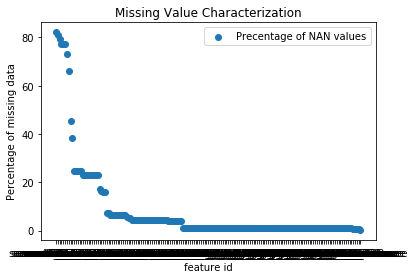

In [4]:

train_df_na = pd.DataFrame(train_df_na)
train_df_na.columns = ['Precentage of NAN values']
plt.scatter(x = train_df_na.index, y = train_df_na['Precentage of NAN values'])
plt.legend(train_df_na.columns), plt.ylabel('Percentage of missing data')
plt.xlabel('feature id'), plt.title('Missing Value Characterization')


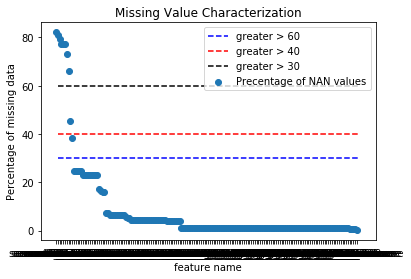

In [181]:
plt.scatter(x = train_df_na.index, y = train_df_na['Precentage of NAN values'])
plt.ylabel('Percentage of missing data')
plt.xlabel('feature name'), plt.title('Missing Value Characterization')
xs = np.linspace(1,len(train_df_na['Precentage of NAN values'])+1,len(train_df_na['Precentage of NAN values'])+1)
horiz_line_data = np.array([30 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'b--') 
horiz_line_data = np.array([40 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([60 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'k--') 
plt.legend(['greater > 60','greater > 40' ,'greater > 30', (train_df_na.columns)[0]], loc  = 1)

After plotting the percentage of missing data in each column/feature of the data sets. The team identified that were three possible threshold values that can be used to remove the columns from the data set. There three different major gaps in the missing value percentage scatter plot. A Random Forest regression was applied to all 4 cases of the threshold to determine the best threshold in terms of minimizing the empirical error.

In [6]:
feature_drop = train_df_na[train_df_na['Precentage of NAN values'] > 60].index
Data_train = train_df.drop(columns = feature_drop) 
Data_train = Data_train.fillna(0)

In [72]:
#Data_train.isnull()
#Data_train.describe(include = 'all')

#### Creating a Training and validation set to train the model base of the reliable feature 

Text(0, 0.5, 'Count')

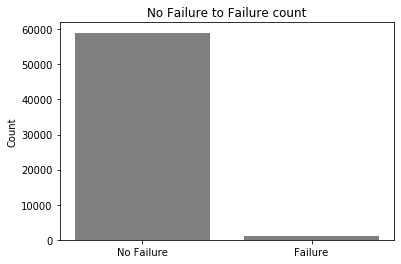

In [36]:
X = Data_train[Data_train.columns[Data_train.columns != 'target']]
X = preprocessing.normalize(X)
y = Data_train['target']
train_X, val_X, train_y, val_y  = train_test_split(X, y, test_size=0.30, random_state=42)
count = np.array([(y[y==0]).count(),(y[y==1]).count()])
objects = ('No Failure', 'Failure')
plt.bar(np.arange(len(objects)), count, align='center', alpha=0.5, color='black')
plt.title('No Failure to Failure count'),plt.xticks(np.arange(len(objects)), objects)
plt.ylabel('Count')

In [14]:
descision_tree_model = tree.DecisionTreeClassifier(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print((val_mae))

0.012222222222222223


The Decision Tree Classifier algorithm when trained over 0.8 percent of the train was able to achieve an empirical error of 1.23%. The Tree performs better than SVM before any adjustment. Decision Tree algorithm only trains based on the empirical and does not try to optimize the margin between the two different classes. To take margin to take into account we implemented a Decision Tree Regressor algorithm. In theory, the regression tree algorithm provides control over the generalization error. In practice, we found that there was no difference in the error between the Classifier and Regressor. 

In [16]:
descision_tree_model = DecisionTreeRegressor(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print((val_mae))

0.012222222222222223


In [9]:
test_df_no_id  = test_df.drop(columns= 'id')
test_df_needed = test_df_no_id.drop(columns = feature_drop)
test_df_needed = test_df_needed.replace('na',np.nan)
test_df_needed = test_df_needed.fillna(0)
test_df_needed = preprocessing.normalize(test_df_needed)
#test_preds = descision_tree_model.predict(test_df_needed).astype(int)

In [18]:
output = pd.DataFrame({'Id': test_df['id'],
                       'target': test_preds})
output.to_csv('submission.csv', index=False)

In [19]:
descision_tree_model = RandomForestRegressor(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X).astype(int)
val_mae = mean_absolute_error(val_predictions, val_y)
print((val_mae))

/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.013030303030303031


In [21]:
output = pd.DataFrame({'Id': test_df['id'],
                       'target': test_preds})
output.to_csv('submission_2.csv', index=False)


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(train_X, train_y) 
val_predictions = clf.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print(val_mae)

0.016777777777777777


When approaching the failure prediction part of the Challenge, and initially used a Support vector classifier. Using the basic configuration of the support vector classifier, the team observes a mean absolute error of 1.68%. After using the SVC, the team decided to implement a decision tree classifier to predict a possible failure. The performance of the SVC model was suboptimal when compared to the Decision Tree Classifier. 

In [19]:
from xgboost import XGBClassifier
my_model =XGBClassifier()
my_model.fit(train_X, train_y, 
             early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)],
             verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
my_model.score(val_X, val_y)
test_preds = my_model.predict(test_df_needed)

In [21]:
output = pd.DataFrame({'Id': test_df['id'],
                       'target': test_preds})
output.to_csv('submission_2.csv', index=False)

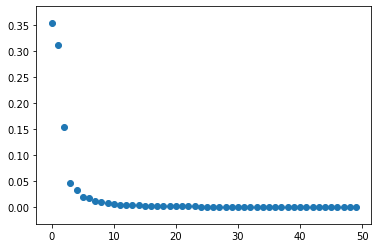

In [118]:
plt.scatter(y = pca.explained_variance_ratio_, x = range(0,len(pca.explained_variance_ratio_)) )

In [119]:
trainx_pca.shape

(42000, 50)

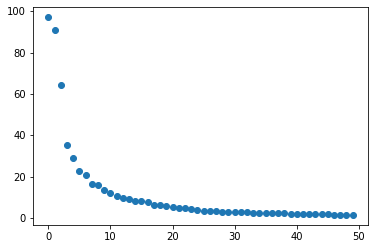

In [120]:
plt.scatter(y = pca.singular_values_, x = range(0,len(pca.singular_values_)) )

In [37]:
from sklearn.decomposition import PCA
error_over = []
for i in range(1,16):
    pca = PCA(n_components = i*5)
    trainx_pca = pca.fit_transform(train_X)
    descision_tree_model = RandomForestRegressor(random_state=1)
    # Fit Model
    descision_tree_model.fit(trainx_pca, train_y)

    # Make validation predictions and calculate mean absolute error
    val_predictions = descision_tree_model.predict(pca.transform(val_X)).astype(int)
    val_mae = mean_absolute_error(val_predictions, val_y)
    error_over.append(val_mae)

/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhay/anaconda3/lib/python3.7/site-pa

(0.015564999999999999, 0.01660888888888889)

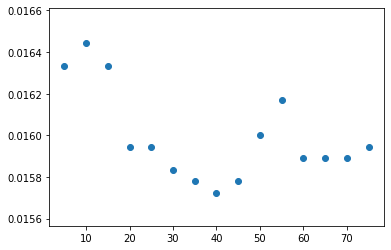

In [38]:
error_over= np.array(error_over)
plt.scatter(y = error_over , x = np.linspace(1,15,15)*5)
plt.ylim((min(error_over)-0.01*min(error_over), max(error_over) + 0.01*max(error_over)))

In [42]:
error_over= np.array(error_over)
error_over*100

array([1.63333333, 1.64444444, 1.63333333, 1.59444444, 1.59444444,
       1.58333333, 1.57777778, 1.57222222, 1.57777778, 1.6       ,
       1.61666667, 1.58888889, 1.58888889, 1.58888889, 1.59444444])

In [44]:
pca = PCA(n_components = 1*5)
trainx_pca = pca.fit_transform(train_X)

In [80]:
for i in range(0,5):
    k = np.amax(pca.components_[:][i])
    print(np.where(pca.components_ == k))

(array([0]), array([82]))
(array([1]), array([1]))
(array([2]), array([147]))
(array([3]), array([141]))
(array([4]), array([71]))


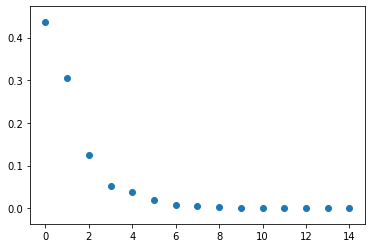

In [172]:
matrix = pca.components_ >= 0
value = matrix[:][0]+matrix[:][1]+matrix[:][2]+matrix[:][3]


x_false = x[value== False]

postpac_data = np.delete(train_X,x[value== False],axis=1)
postpac_test =  np.delete(val_X,x[value== False],axis=1)
pca2 = PCA(n_components = 15)
pca2.fit_transform(postpac_data)

plt.scatter(y = pca2.explained_variance_ratio_, x = range(0,len(pca2.explained_variance_ratio_)) )

In [180]:
pca2 = PCA(n_components = 6)
pca2_train = pca2.fit_transform(postpac_data)
pca2_val = pca2.transform(postpac_test)


descision_tree_model = RandomForestRegressor(random_state=1)
    # Fit Model
descision_tree_model.fit(pca2_train, train_y)
# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(pca2_val).astype(int)
val_mae = mean_absolute_error(val_predictions, val_y)
print(val_mae)


/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.016277777777777776


In [175]:
pca2_train.shape

(42000, 6)

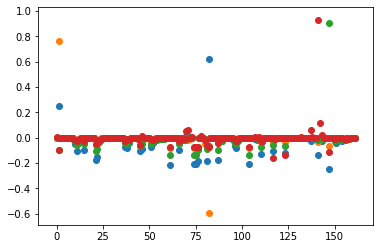

In [139]:
for i in range(0,4):
    plt.scatter(y = pca.components_[:][i], x = range(0,len(pca.components_[:][i])))